## Multi-threading case

In [1]:
!pip3 install selenium==4.6.0
!pip3 install webdriver-manager==3.8.5
!pip3 install diagrams==0.23.1
!pip3 install retry==0.9.2
!pip3 install loguru==0.6.0

In [2]:
import os
import threading
import time

from selenium import webdriver
from selenium.webdriver.common.by import By

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.utils import ChromeType
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from IPython import display
from IPython.display import Image
from base64 import b64decode, urlsafe_b64decode, decodebytes

from retry import retry
from loguru import logger
from timeit import default_timer as timer
from datetime import timedelta

In [3]:
def saveBase64Image(img_data, filename):
    with open(f"src/{filename}", "wb") as fh:
        fh.write(b64decode(img_data))

In [4]:
logger.add("file_{time}.log", level='DEBUG')

1

In [5]:
chrome_service = Service(ChromeDriverManager().install())
logger.info("Install chrome driver")

[WDM] - Downloading: 100%|█████████████████| 8.61M/8.61M [00:02<00:00, 4.23MB/s]
2022-12-18 00:00:08.395 | INFO     | __main__:<module>:2 - Install chrome driver


In [6]:
# Get environment variables
IS_GITHUB_ACTION = os.getenv('IS_GITHUB_ACTION')
logger.info("Set github action env")

2022-12-18 00:00:08.400 | INFO     | __main__:<module>:3 - Set github action env


In [7]:
chrome_options = Options()
if IS_GITHUB_ACTION:
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)

logger.info("Set chrome driver options")

2022-12-18 00:00:08.407 | INFO     | __main__:<module>:17 - Set chrome driver options


In [8]:
logger.info("Run chrome driver")
browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
browser.set_window_size(1920, 1080)
browser.get('https://www.gotokyo.org/kr/destinations/index.html')
logger.debug("Load main page done url {url}", url='https://www.gotokyo.org/kr/destinations/index.html')

2022-12-18 00:00:08.414 | INFO     | __main__:<module>:1 - Run chrome driver
2022-12-18 00:00:19.118 | DEBUG    | __main__:<module>:5 - Load main page done url https://www.gotokyo.org/kr/destinations/index.html


2022-12-18 00:00:19.126 | INFO     | __main__:<module>:1 - Crawl place list
2022-12-18 00:00:19.149 | DEBUG    | __main__:<module>:3 - Place list len: 9


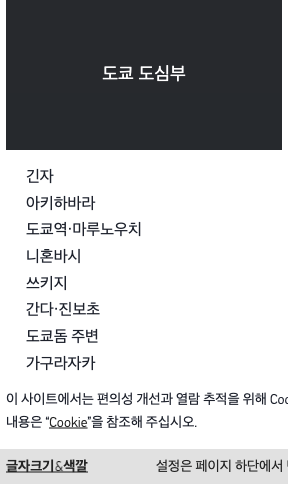

In [9]:
logger.info("Crawl place list")
placeList = browser.find_elements(By.CSS_SELECTOR, '#tmp_explore_tokyo > div > ul.mod_figure_list > li');
logger.debug("Place list len: {place_len}", place_len = len(placeList))
display.Image(b64decode(placeList[0].screenshot_as_base64))

# saveBase64Image(placeList[0].screenshot_as_base64, "test.png")

In [10]:
def getAreaListFromPlace(place):
    try:
        return [(area.text, area.get_attribute("href")) for area in place.find_elements(By.CSS_SELECTOR, "a + ul > li > a")]
    except Exception as e:
        logger.error("Cannot get place data, e: {err}", place=place, err=e)
    return []


In [11]:
logger.info("Crawl place's area data")
placeAndUrlList = [(place.find_element(By.TAG_NAME, 'a').text, 
                    place.find_element(By.TAG_NAME, 'a').get_attribute('href'),
                    getAreaListFromPlace(place)
                   ) for place in placeList]
logger.debug("Place's area data: {data}", data=placeAndUrlList)
# placeAndUrlList

2022-12-18 00:00:19.325 | INFO     | __main__:<module>:1 - Crawl place's area data
2022-12-18 00:00:20.994 | DEBUG    | __main__:<module>:6 - Place's area data: [('도쿄 도심부', 'https://www.gotokyo.org/kr/destinations/central-tokyo/index.html', [('긴자', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html'), ('아키하바라', 'https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html'), ('도쿄역・마루노우치', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html'), ('니혼바시', 'https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html'), ('쓰키지', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html'), ('간다・진보초', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/index.html'), ('도쿄돔 주변', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-dome-and-around/index.html'), ('가구라자카', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kagurazaka/index.html'), ('아카사카', '

In [12]:
logger.info("Close place crawling browser")
browser.close()

2022-12-18 00:00:21.000 | INFO     | __main__:<module>:1 - Close place crawling browser


## Get area's detail info

In [13]:
def getSlideItems(slideItemList):
    logger.debug("Slider item list len {}", len(slideItemList))
    try:
        return [{
            'contentName': slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'),
            'contentImg': slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'),
            'contentDetailURL': slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href')
        } for slideItem in slideItemList]
#     [(slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'), # tour content name
#             slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'), # tour content img
#             slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href') # tour content detail link
#             ) for slideItem in slideItemList]
    except Exception as e:
        logger.error("Slider item error {}", e)

In [29]:
@retry(Exception, tries=3, delay=4)
def getSlideList(browser):
    sliderCrawlResult = []
    try:
        logger.info("Remove banner to load slider list")
        browser.execute_script("document.querySelector('div.section_banner_top').remove();document.querySelector('div.left_block').remove();jQuery(window).scroll();")
        logger.info("Banner removed")
    except Exception as e:
        logger.error("Remove banner has an error {}", e)
    logger.info("Crawl slider items")
    sliderCrawlResult = [{
            'silderTitle': slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text,
            'silderItems': getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]),
        } for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
#     [(
#         slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text, #title
#         getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]) #slider's items
#         ) for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
    logger.debug("Crawl slider items result {}", sliderCrawlResult)
    if sum([len(sliderItemList['silderItems']) for sliderItemList in sliderCrawlResult]) <= 0:
        logger.info("Slider is empty, raise error");
        raise Exception('Data not found')
    return sliderCrawlResult
    
# getSlideList(browser)

In [15]:
@retry(Exception, tries=3, delay=2)
def initHeadlessBrowser():
    logger.info("Setup headless browser options")
    chrome_options = Options()
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage",
        "--enable-automation",
        "start-maximized",
        "disable-infobars"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)
    browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
    browser.set_window_size(1920, 1080)
    return browser

In [16]:
def resizeBrowserHeightAsContentFullHeight(browser):
    logger.info("Update browser's height same as content height")
    requireHeight = browser.execute_script('return document.body.parentNode.scrollHeight')
    logger.debug("Current content height {}", requireHeight)
    browser.set_window_size(1920, requireHeight)
    browser.execute_script("document.querySelector('div.section_banner_top.setheight').style.height = '464px';")
    logger.info("Manually set banner's height")
    time.sleep(2) # Because of pictures load time

In [21]:
def getAreaInfoProcess(areaName, url, queue=None, idx=None):
    logger.debug("Area crawling process start, url: {}", url)
    slidItemList = []
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        resizeBrowserHeightAsContentFullHeight(browser)
        saveBase64Image(browser.find_element(By.CSS_SELECTOR, "div.left_block").screenshot_as_base64, f'{areaName}.png')
        slidItemList = getSlideList(browser)
        logger.info("Get slider item done")
        if queue is not None:
            queue.put({
                'idx': idx, 
                'slidItemList': slidItemList
            })
    except Exception as e:
        logger.error('Cannot get area info data {}', e)
    finally:
        browser.close()
    logger.info("Area crawling browser closed")
    return slidItemList

In [32]:
start = timer()
getAreaInfoProcess('ginza', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html')
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-17 23:48:05.906 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-17 23:48:05.908 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-17 23:48:06.918 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-17 23:48:15.908 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-17 23:48:15.922 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-17 23:48:16.031 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-17 23:48:19.175 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-17 23:48:19.189 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-17 23:48:1

2022-12-17 23:48:22.466 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-17 23:48:22.523 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-17 23:48:22.524 | DEBUG    | __main__:<module>:4 - Process take time 0:00:16.617257


## Single thread, Single process

In [43]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        areaCrawlingResult.append(getAreaInfoProcess(area[0], area[1]))
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 10:37:38.962 | DEBUG    | __main__:<module>:4 - place: 도쿄 도심부 len: 11
2022-12-11 10:37:38.964 | DEBUG    | __main__:<module>:6 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:38.965 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:38.966 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:37:39.500 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:41.919 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:37:41.928 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 7829
2022-12-11 10:37:42.039 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7

2022-12-11 10:37:47.989 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:37:48.046 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:37:48.047 | DEBUG    | __main__:<module>:6 - area: 아키하바라 url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-11 10:37:48.048 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-11 10:37:48.049 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:37:48.524 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-11 10:37:50.274 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:37:50.285 | DEBUG    | __main__:resizeBrowserHeightAsContentFullH

2022-12-11 10:37:56.418 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:37:56.475 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:37:56.476 | DEBUG    | __main__:<module>:6 - area: 도쿄역・마루노우치 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-11 10:37:56.478 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-11 10:37:56.479 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:37:56.954 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-11 10:37:59.428 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:37:5

2022-12-11 10:38:07.392 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:38:07.448 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:38:07.449 | DEBUG    | __main__:<module>:6 - area: 니혼바시 url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-11 10:38:07.450 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-11 10:38:07.451 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:38:07.931 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-11 10:38:09.789 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:38:09.831 | DEBUG    | __main__:resizeBrowserHeightAsContentFul

2022-12-11 10:38:20.986 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:38:20.987 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('종교적인 장소', []), ('시장', []), ('도쿄 로컬음식', [])]
2022-12-11 10:38:20.988 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 10:38:22.990 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 10:38:22.998 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010b7a8f38 chromedriver + 4910904
1   chromedriver                        0x000000010b728a03 chromedriver + 4385283
2   chromedriver                        0x000000010b36d747 chromedriver + 472903
3   chromedriver                        0x000000010b371d28 chromedriver + 490792
4   chromedriver                 

2022-12-11 10:38:30.581 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 10:38:30.701 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('종교적인 장소', [('야스쿠니 신사', 'https://www.gotokyo.org/kr/spot/466/images/5653_1_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/466/index.html'), ('간다묘진 신사', 'https://www.gotokyo.org/kr/spot/17/images/17_0093_4_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/17/index.html'), ('가톨릭 간다 교회', 'https://www.gotokyo.org/kr/spot/97/images/97_3_670x450_1.jpg', 'https://www.gotokyo.org/kr/spot/97/index.html')]), ('아트・박물관', [('메이지대학 현대 만화 도서관', 'https://www.gotokyo.org/en/spot/323/images/323_670x450.jpg', 'https://www.gotokyo.org/kr/spot/323/index.html'), ('쇼케이관 전쟁 상병자 사료관', 'https://www.gotokyo.org/kr/spot/1180/images/5053_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1180/index.html'), ('과학기술관', 'https://www.gotokyo.org/en/spot/435/images/435_0311_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/435/index.html'), ('도쿄 

2022-12-11 10:38:45.227 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:38:45.260 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:38:45.284 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:38:45.309 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:38:45.333 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:38:45.334 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('전통 문화체험', []), ('종교적인 장소', []), ('아트・박물관', []), ('기타 정보', [])]
2022-12-11 10:38:45.335 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 10:38:47.340 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 10:38:47.348 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktra

2022-12-11 10:38:55.220 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:38:55.241 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 10:38:55.358 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 10:38:55.432 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-11 10:38:55.610 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('극장・영화관', [('아카사카 사카스', 'https://www.gotokyo.org/kr/spot/56/images/56_0137_2_670x450_2.jpg', 'https://www.gotokyo.org/kr/spot/56/index.html'), ('국립극장', 'https://www.gotokyo.org/en/spot/475/images/475_0334_2_670x450.jpg', 'https://www.gotokyo.org/kr/spot/475/index.html'), ('TBS 아카사카 ACT 시어터', 'https://www.gotokyo.org/kr/spot/550/images/5731_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/550/index.html')]), ('역사를 따라서', [('도라노몬 고토히라궁', 'https://www.gotokyo.org/en/spot/254/images/5135_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/254/index.html'), ('영빈관 아카사

2022-12-11 10:39:03.426 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:39:03.428 | DEBUG    | __main__:<module>:6 - area: 하마마쓰초 url: https://www.gotokyo.org/kr/destinations/central-tokyo/hamamatsucho/index.html
2022-12-11 10:39:03.429 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/hamamatsucho/index.html
2022-12-11 10:39:03.430 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:39:03.907 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/hamamatsucho/index.html
2022-12-11 10:39:05.806 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:39:05.822 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 4612
2022-12-11 10:39:05.928 | INFO     | __main_

2022-12-11 10:39:16.617 | DEBUG    | __main__:<module>:6 - area: 야나카・네즈 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/yanaka-and-nezu/index.html
2022-12-11 10:39:16.619 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/yanaka-and-nezu/index.html
2022-12-11 10:39:16.620 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:39:17.096 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/northern-tokyo/yanaka-and-nezu/index.html
2022-12-11 10:39:18.892 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:39:18.904 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6993
2022-12-11 10:39:19.021 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-11 1

2022-12-11 10:39:33.046 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:39:33.061 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 8
2022-12-11 10:39:33.310 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 10:39:33.414 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 10:39:33.563 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-11 10:39:33.794 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-11 10:39:33.828 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('호텔', [('쓰쿠바 호텔', 'https://www.gotokyo.org/en/spot/1629/images/1629_0920_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1629/index.html'), ('호텔 뉴 우에노', 'https://www.gotokyo.org/en/spot/1631/images/1631_0922_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1631/index.html'), ('엘리트 인 도쿄', 'https://www.gotokyo.org/en/spot/1688/images/1688_0968_1_670x450.jpg', 'https://www.gotokyo.org/kr/s

2022-12-11 10:39:41.695 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:39:41.751 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:39:41.753 | DEBUG    | __main__:<module>:6 - area: 닛포리 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/nippori/index.html
2022-12-11 10:39:41.754 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/northern-tokyo/nippori/index.html
2022-12-11 10:39:41.756 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:39:42.234 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/northern-tokyo/nippori/index.html
2022-12-11 10:39:44.393 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:39:44.408 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight

2022-12-11 10:39:57.654 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:39:57.674 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 10:39:57.754 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 10:39:57.849 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 10:39:57.910 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('쇼핑스트리트・상점가', [('주조긴자상점가', 'https://www.gotokyo.org/kr/spot/670/images/670_0438_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/670/index.html'), ('아카바네 이치반가이 상점가', 'https://www.gotokyo.org/kr/spot/90/images/90_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/90/index.html')]), ('공원・정원', [('구 후루카와 정원', 'https://www.gotokyo.org/en/spot/421/images/421_main_450.jpg', 'https://www.gotokyo.org/kr/spot/421/index.html'), ('', 'https://www.gotokyo.org/shared/images/img_noimage_670x450.jpg', 'https://www.gotokyo.org/kr/spot/296/index.html'), ('아스카야마 공원', 'https://ww

2022-12-11 10:40:10.773 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-11 10:40:10.773 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:40:10.805 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:40:10.826 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:40:10.845 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-11 10:40:10.846 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('전통 문화체험', []), ('공원・정원', []), ('사찰・신사', [])]
2022-12-11 10:40:10.846 | INFO     | __main__:getSlideList:17 - Slider is empty, raise error
2022-12-11 10:40:12.848 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-11 10:40:12.854 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver       

2022-12-11 10:40:20.810 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:40:20.830 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 10
2022-12-11 10:40:21.159 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 10:40:21.228 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-11 10:40:21.296 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('만화・애니메이션', [('게이세이 전철 요쓰기역', 'https://www.gotokyo.org/en/spot/1841/images/1841_main_450.jpg', 'https://www.gotokyo.org/kr/spot/1841/index.html'), ('몬치치 공원', 'https://www.gotokyo.org/en/spot/1725/images/450.jpg', 'https://www.gotokyo.org/kr/spot/1725/index.html'), ('가메아리카토리 신사', 'https://www.gotokyo.org/en/spot/1121/images/1121_0859_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1121/index.html'), ('리카짱 맨홀', 'https://www.gotokyo.org/en/spot/1808/images/1808_rikachan_main_670_450.jpg', 'https://www.gotokyo.org/kr/spot/1808/index.html'), ('토미카 맨홀', 'https:/

2022-12-11 10:40:29.067 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:40:29.123 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:40:29.125 | DEBUG    | __main__:<module>:4 - place: 도쿄동부 len: 7
2022-12-11 10:40:29.126 | DEBUG    | __main__:<module>:6 - area: 아사쿠사 url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/asakusa/index.html
2022-12-11 10:40:29.127 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/asakusa/index.html
2022-12-11 10:40:29.128 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:40:29.601 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/asakusa/index.html
2022-12-11 10:40:32.897 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-

2022-12-11 10:40:41.570 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:40:41.626 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:40:41.628 | DEBUG    | __main__:<module>:6 - area: 료고쿠 url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/ryogoku/index.html
2022-12-11 10:40:41.628 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/ryogoku/index.html
2022-12-11 10:40:41.629 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:40:42.097 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/ryogoku/index.html
2022-12-11 10:40:44.268 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:40:44.278 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 

2022-12-11 10:40:58.051 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.98)
Stacktrace:
0   chromedriver                        0x000000010b7a8f38 chromedriver + 4910904
1   chromedriver                        0x000000010b728a03 chromedriver + 4385283
2   chromedriver                        0x000000010b36d747 chromedriver + 472903
3   chromedriver                        0x000000010b371d28 chromedriver + 490792
4   chromedriver                        0x000000010b3719f6 chromedriver + 489974
5   chromedriver                        0x000000010b37294e chromedriver + 493902
6   chromedriver                        0x000000010b3f3fef chromedriver + 1023983
7   chromedriver                        0x000000010b3d8112 chromedriver + 909586
8   chromedriver                        0x000000010b3f328e chromedriver + 1020558
9   chromedriver                        

2022-12-11 10:41:06.205 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:41:06.224 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 10:41:06.385 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-11 10:41:06.535 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-11 10:41:06.720 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('가족이 함께 즐기기', [('키자니아 도쿄', 'https://www.gotokyo.org/kr/spot/57/images/57_main_450.jpg', 'https://www.gotokyo.org/kr/spot/57/index.html'), ('도쿄도 유메노시마 열대식물관', 'https://www.gotokyo.org/kr/spot/483/images/483_0340_2_670x450_2.jpg', 'https://www.gotokyo.org/kr/spot/483/index.html'), ('가스테나니 가스 과학관', 'https://www.gotokyo.org/en/spot/881/images/881_0787_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/881/index.html'), ('어반독 라라포트 도요스', 'https://www.gotokyo.org/en/spot/522/images/522_0691_4_670x450.jpg', 'https://www.gotokyo.org/kr/spot/522/index.html')]), ('체험・활동'

2022-12-11 10:41:15.610 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:41:15.666 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:41:15.667 | DEBUG    | __main__:<module>:6 - area: 후카가와 url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/fukagawa/index.html
2022-12-11 10:41:15.667 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/fukagawa/index.html
2022-12-11 10:41:15.668 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:41:16.141 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/fukagawa/index.html
2022-12-11 10:41:18.211 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:41:18.223 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeigh

2022-12-11 10:41:30.615 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-11 10:41:30.636 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-11 10:41:30.833 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-11 10:41:30.922 | DEBUG    | __main__:getSlideList:15 - Crawl slider items result [('공원・정원', [('우키타 공원', 'https://www.gotokyo.org/en/spot/1148/images/5020_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1148/index.html'), ('귀여운 겨울꽃을 찾아 도쿄의 유명 정원ㆍ공원을 둘러보자', 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190212/images/190212_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190212/topics.html'), ('가사이 임해공원', 'https://www.gotokyo.org/en/spot/277/images/277_0216_6_670x450.jpg', 'https://www.gotokyo.org/kr/spot/277/index.html'), ('시노자키 공원', 'https://www.gotokyo.org/en/spot/1108/images/1108_0054_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/1108/index.html'), ('고이와 창포원', 'https://www.gotokyo.org/

2022-12-11 10:41:41.341 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-11 10:41:41.397 | INFO     | __main__:getAreaInfoProcess:18 - Area crawling browser closed
2022-12-11 10:41:41.398 | DEBUG    | __main__:<module>:6 - area: 시부야 url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 10:41:41.399 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 10:41:41.400 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:41:41.879 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html


MaxRetryError: HTTPConnectionPool(host='localhost', port=51125): Max retries exceeded with url: /session/9652fd5301d511bd6ab932668111ee7b/window (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7faab0046880>: Failed to establish a new connection: [Errno 61] Connection refused'))

```
2022-12-10 22:26:21.084 | DEBUG    | __main__:<module>:9 - Process take time 0:12:11.764783
```

In [ ]:
areaCrawlingResult

In [ ]:
areaCrawlingResult[0][0]

## Single process, Multi-threading

In [22]:
from queue import Queue

In [30]:
start = timer()
areaCrawlingResult = []
queue = Queue()
idx = 0
for place in placeAndUrlList:
    threadList = []
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        threadList.append(threading.Thread(target=getAreaInfoProcess, args=[area[0], area[1], queue, idx]))
        idx += 1
        
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]
    
    while not queue.empty():
        areaCrawlingResult.append(queue.get())
    time.sleep(2)

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-18 00:26:25.566 | DEBUG    | __main__:<module>:7 - place: 도쿄 도심부 len: 11
2022-12-18 00:26:25.567 | DEBUG    | __main__:<module>:9 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-18 00:26:25.568 | DEBUG    | __main__:<module>:9 - area: 아키하바라 url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-18 00:26:25.569 | DEBUG    | __main__:<module>:9 - area: 도쿄역・마루노우치 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-18 00:26:25.570 | DEBUG    | __main__:<module>:9 - area: 니혼바시 url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-18 00:26:25.571 | DEBUG    | __main__:<module>:9 - area: 쓰키지 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html
2022-12-18 00:26:25.572 | DEBUG    | __main__:<module>:9 - area: 간다・진보초 url: https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/in

2022-12-18 00:26:33.317 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:34.008 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:26:34.112 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5008
2022-12-18 00:26:34.372 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:26:34.411 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:35.104 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5842
2022-12-18 00:26:35.105 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:26:35.121 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 4612
2022-

2022-12-18 00:26:38.837 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:38.905 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:39.098 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '종교적인 장소', 'silderItems': []}, {'silderTitle': '시장', 'silderItems': [{'contentName': '쓰키지 장외시장에 ‘쓰키지 우오가시’ 오픈!', 'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/181228/images/181228_thum_400.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/181228/topics.html'}, {'contentName': '말차와 센차를 간편하고 세련되게 즐기는 카페&스탠드', 'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190415/images/190415_thum_400.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190415/topics.html'}, {'contentName': '쓰키지 장외시장', 'contentImg': 'https://www.gotokyo.org/kr/spot/65/images/4512_1_670x450_3.jpg', 'contentDetailURL': 'h

2022-12-18 00:26:40.727 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '호텔', 'silderItems': []}, {'silderTitle': '공원・정원', 'silderItems': []}, {'silderTitle': '아트・박물관', 'silderItems': []}]
2022-12-18 00:26:40.728 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:26:40.906 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 9
2022-12-18 00:26:41.329 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:26:41.346 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:26:41.348 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:26:41.392 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:41.427 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:41.476 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:41.477 | DEBUG    | __main__:getSlideList:19 - Crawl slider 

2022-12-18 00:26:42.239 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:42.342 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:42.374 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:26:42.553 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:26:42.555 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:26:42.599 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:42.627 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:42.654 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:42.683 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:26:42.685 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아트・디자인', 'silderItems': []}, {'silderTitle': '쇼핑몰・백화점', 'silderItems': []}, {'silderTitle': '호텔'

2022-12-18 00:26:43.887 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:43.943 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:44.643 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:26:44.650 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 4939

2022-12-18 00:26:45.277 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:45.333 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:45.485 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:26:45.492 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 4939

2022-12-18 00:26:47.271 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:47.328 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:47.598 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:26:47.604 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 4939

2022-12-18 00:26:48.941 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:26:48.997 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:26:51.000 | DEBUG    | __main__:<module>:7 - place: 도쿄북부 len: 10
2022-12-18 00:26:51.002 | DEBUG    | __main__:<module>:9 - area: 이케부쿠로 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/ikebukuro/index.html
2022-12-18 00:26:51.003 | DEBUG    | __main__:<module>:9 - area: 야나카・네즈 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/yanaka-and-nezu/index.html
2022-12-18 00:26:51.004 | DEBUG    | __main__:<module>:9 - area: 우에노 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/ueno/index.html
2022-12-18 00:26:51.005 | DEBUG    | __main__:<module>:9 - area: 스가모 url: https://www.gotokyo.org/kr/destinations/northern-tokyo/sugamo/index.html
2022-12-18 00:26:51.006 | DEBUG    | __main__:<module>:9 - area: 닛포리 url: https://www.gotokyo.org/kr/destinations/northern-tokyo

2022-12-18 00:26:57.548 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5377
2022-12-18 00:26:57.588 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:57.671 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:57.805 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:26:57.918 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6239
2022-12-18 00:26:58.083 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:58.337 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6974
2022-12-18 00:26:58.446 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:26:58.891 | INFO     | __ma

2022-12-18 00:27:03.549 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:03.550 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:03.553 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:03.586 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:27:03.588 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:03.597 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:27:03.611 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:03.643 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:03.647 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:03.695 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:03.700 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:27:03.731 | DEBUG   

2022-12-18 00:27:05.326 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:05.343 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:05.432 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:05.547 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:05.615 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '쇼핑스트리트・상점가', 'silderItems': [{'contentName': '주조긴자상점가', 'contentImg': 'https://www.gotokyo.org/kr/spot/670/images/670_0438_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/670/index.html'}, {'contentName': '아카바네 이치반가이 상점가', 'contentImg': 'https://www.gotokyo.org/kr/spot/90/images/90_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/90/index.html'}]}, {'silderTitle': '공원・정원', 'silderItems': [{'contentName': '구 후루카와 정원', 'contentImg': 'https://www.gotokyo.org/en/spot/421/images/421_main_450.jpg', 'contentD

2022-12-18 00:27:07.349 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:07.368 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 10
2022-12-18 00:27:07.706 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:07.791 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:07.865 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '만화・애니메이션', 'silderItems': [{'contentName': '게이세이 전철 요쓰기역', 'contentImg': 'https://www.gotokyo.org/en/spot/1841/images/1841_main_450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1841/index.html'}, {'contentName': '몬치치 공원', 'contentImg': 'https://www.gotokyo.org/en/spot/1725/images/450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1725/index.html'}, {'contentName': '가메아리카토리 신사', 'contentImg': 'https://www.gotokyo.org/en/spot/1121/images/1121_0859_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/11

2022-12-18 00:27:08.554 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:08.561 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:08.567 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 493902
6   chromedriver                        0x00000001078abfef chromedriver + 1023983
7   chromedriver  

2022-12-18 00:27:08.884 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:08.920 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:08.939 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:09.052 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:27:09.199 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-18 00:27:09.460 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:27:09.499 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '호텔', 'silderItems': [{'contentName': '쓰쿠바 호텔', 'contentImg': 'https://www.gotokyo.org/en/spot/1629/images/1629_0920_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1629/index.html'}, {'contentName': '호텔 뉴 우에노', 'contentImg': 'https://www.gotokyo.org/en/spot/1631/images/1631_0922_1_670x450.jpg', 'contentDetailURL': 'https://www.goto

2022-12-18 00:27:11.583 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 00:27:11.586 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 00:27:12.324 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/asakusa/index.html
2022-12-18 00:27:12.619 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/ryogoku/index.html
2022-12-18 00:27:12.619 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/kasai/index.html
2022-12-18 00:27:12.620 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/fukagawa/index.html
2022-12-18 00:27:12.687 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/eastern-tokyo/kiy

2022-12-18 00:27:21.874 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:21.901 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-18 00:27:22.219 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:22.260 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:22.291 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromed

2022-12-18 00:27:23.013 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:23.023 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:27:23.075 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:23.181 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:23.208 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:27:23.209 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:23.252 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:23.279 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:23.303 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-18 00:27:23.306 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:23.329 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:23.355 | DEBU

2022-12-18 00:27:24.396 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:24.415 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 8
2022-12-18 00:27:24.431 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '공원・정원', 'silderItems': [{'contentName': '센다이보리가와 강 공원', 'contentImg': 'https://www.gotokyo.org/kr/spot/1097/images/1097_0044_1_670x450_1.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1097/index.html'}, {'contentName': '미나미스나 도로공원', 'contentImg': 'https://www.gotokyo.org/en/spot/1054/images/1054_0023_2_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1054/index.html'}, {'contentName': '요코줏켄가와 강 친수공원', 'contentImg': 'https://www.gotokyo.org/en/spot/1099/images/1099_0857_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1099/index.html'}, {'contentName': '후루이시바가와 강 친수공원', 'contentImg': 'https://www.gotokyo.org/en/spot/1098/images/1098_0856_1_670x450.jpg', 'contentDet

2022-12-18 00:27:26.681 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:26.779 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:26.901 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:27.032 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:27.143 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:27:27.241 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '쇼핑스트리트・상점가', 'silderItems': [{'contentName': '시타마치닌조 기라키라타치바나 상점가', 'contentImg': 'https://www.gotokyo.org/en/spot/915/images/915_0535_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/915/index.html'}, {'contentName': '하토노마치도리 상점가', 'contentImg': 'https://www.gotokyo.org/kr/spot/858/images/858_0519_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/858/index.html'}]}, {'silderTitle': '랜드마크', 'silderItems': [{'conten

2022-12-18 00:27:28.787 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:28.842 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:30.846 | DEBUG    | __main__:<module>:7 - place: 도쿄서부 len: 12
2022-12-18 00:27:30.847 | DEBUG    | __main__:<module>:9 - area: 신주쿠 url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-18 00:27:30.848 | DEBUG    | __main__:<module>:9 - area: 시부야 url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-18 00:27:30.850 | DEBUG    | __main__:<module>:9 - area: 하라주쿠 url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-18 00:27:30.851 | DEBUG    | __main__:<module>:9 - area: 아오야마・오모테산도 url: https://www.gotokyo.org/kr/destinations/western-tokyo/aoyama-and-omotesando/index.html
2022-12-18 00:27:30.852 | DEBUG    | __main__:<module>:9 - area: 시모키타자와 url: https://www.gotokyo.org/kr/destinations/we

2022-12-18 00:27:36.854 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:27:36.874 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:27:37.069 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5895
2022-12-18 00:27:37.196 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:27:37.624 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:27:37.640 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5773
2022-12-18 00:27:37.919 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:27:37.944 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:27:37.95

2022-12-18 00:27:44.090 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:44.149 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:44.803 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:44.868 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:27:44.879 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:44.975 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:45.092 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:45.281 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:27:46.144 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:46.157 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless c

2022-12-18 00:27:47.735 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:27:47.735 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '복고풍', 'silderItems': [{'contentName': '만넨유', 'contentImg': 'https://www.gotokyo.org/en/spot/218/images/218_0740_2_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/218/index.html'}]}, {'silderTitle': '이자카야・요코초', 'silderItems': [{'contentName': '이슬람 요코초', 'contentImg': 'https://www.gotokyo.org/_nopub/kr/spot/1599/images/1599_1363_1_670x450.jpg', 'contentDetailURL': 'javascript:void(0);'}]}, {'silderTitle': '아트・박물관', 'silderItems': [{'contentName': '쓰마미간자시 박물관', 'contentImg': 'https://www.gotokyo.org/en/spot/502/images/502_0687_2_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/502/index.html'}, {'contentName': '하야시 후미코 미술관', 'contentImg': 'https://www.gotokyo.org/kr/spot/948/images/948_0828_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/94

2022-12-18 00:27:50.401 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:50.477 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:50.492 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:50.506 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:27:50.537 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '쇼핑', 'silderItems': []}, {'silderTitle': '호텔', 'silderItems': []}, {'silderTitle': '아트・박물관', 'silderItems': []}, {'silderTitle': '음식', 'silderItems': []}, {'silderTitle': '기타 정보', 'silderItems': []}]
2022-12-18 00:27:50.556 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:27:50.581 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '만화・애니메이션', 'silderItems': [{'contentName': '대괴수 살롱', 'contentImg': 'https://www.gotokyo.org/en/spot/1819/images/1819_daikaijyu_

2022-12-18 00:27:51.363 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:51.421 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:52.986 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:53.006 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:27:53.007 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:27:53.054 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:53.085 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:53.121 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:53.146 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:27:53.147 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아트・디자인', 'silderItems': []}, {'silderTitle': '쇼핑', 'silderItems': []}, {'silderTitle': '팝컬쳐', 's

2022-12-18 00:27:56.209 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:27:56.265 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:27:57.151 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:27:57.156 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 4939

2022-12-18 00:27:59.990 | DEBUG    | __main__:<module>:9 - area: 도쿄타워 주변 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/tokyo-tower-and-around/index.html
2022-12-18 00:27:59.991 | DEBUG    | __main__:<module>:9 - area: 도도로키 계곡 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/todoroki-valley/index.html
2022-12-18 00:27:59.992 | DEBUG    | __main__:<module>:9 - area: 에비스 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/ebisu/index.html
2022-12-18 00:27:59.992 | DEBUG    | __main__:<module>:9 - area: 하네다 공항 주변 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/haneda-airport-and-around/index.html
2022-12-18 00:27:59.993 | DEBUG    | __main__:<module>:9 - area: 지유가오카 url: https://www.gotokyo.org/kr/destinations/southern-tokyo/jiyugaoka/index.html
2022-12-18 00:27:59.994 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/southern-tokyo/odaiba/index.html
2022-12-18 00:27:59.995 | D

2022-12-18 00:28:08.969 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:09.673 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:09.694 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:28:09.695 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:09.767 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:09.768 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6725
2022-12-18 00:28:09.840 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:09.887 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:09.889 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '공원・정원', 'silderItems': []}, {'silderTitle': '아트・박물관', 'silderItems': []}, {'silderTitle': '기타 정보', 'silderItems': []}]
2

2022-12-18 00:28:13.902 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:13.925 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:13.947 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:13.964 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:14.010 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '공원・정원', 'silderItems': []}, {'silderTitle': '아트・박물관', 'silderItems': []}, {'silderTitle': '기타 정보', 'silderItems': [{'contentName': '도도로키 계곡 주변 탐방', 'contentImg': 'https://www.gotokyo.org/kr/story/walks-and-tours/todoroki-valley/images/828_0506_3_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/story/walks-and-tours/todoroki-valley/index.html'}]}]
2022-12-18 00:28:14.022 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:28:14.081 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser clo

2022-12-18 00:28:15.551 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:15.565 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:15.572 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:15.583 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:15.584 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:15.619 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:15.643 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:15.645 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:15.676 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:15.710 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:15.713 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '엔터테인먼트', 'silderItems': []

2022-12-18 00:28:17.061 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:17.084 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:17.087 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:17.091 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 493902
6   chromedriver 

2022-12-18 00:28:18.384 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:18.403 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-18 00:28:18.588 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-18 00:28:18.851 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-18 00:28:19.031 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:19.136 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '호텔', 'silderItems': [{'contentName': '하네다 공항과 연결된 새 시설 ‘하네다 에어포트 가든’에서 호텔, 온천, 쇼핑을 만끽해 보세요', 'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221205/images/221205_main_400.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221205/topics.html'}, {'contentName': '하네다 엑셀 호텔 도큐', 'contentImg': 'https://www.gotokyo.org/en/spot/299/images/299_0834_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr

2022-12-18 00:28:19.723 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:19.744 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:19.860 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:28:19.890 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:28:20.023 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:20.055 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 6
2022-12-18 00:28:20.140 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아트・디자인', 'silderItems': [{'contentName': '모리아츠센터 갤러리', 'contentImg': 'https://www.gotokyo.org/kr/spot/672/images/5827_1_670x450_3.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/672/index.html'}, {'contentName': '도쿄의 여름밤을 연출하는 썸머 일루미네이션', 'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190610/images/190610_thum_400.jpg', 'contentDetailURL

2022-12-18 00:28:20.682 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:28:20.738 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:28:22.741 | DEBUG    | __main__:<module>:7 - place: 이즈 제도ㆍ오가사와라 제도 len: 11
2022-12-18 00:28:22.742 | DEBUG    | __main__:<module>:9 - area: 오시마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/oshima-island/index.html
2022-12-18 00:28:22.744 | DEBUG    | __main__:<module>:9 - area: 도시마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/toshima-island/index.html
2022-12-18 00:28:22.744 | DEBUG    | __main__:<module>:9 - area: 니지마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/niijima-island/index.html
2022-12-18 00:28:22.746 | DEBUG    | __main__:<module>:9 - area: 시키네지마 섬 url: https://www.gotokyo.org/kr/destinations/izu-and-ogasawara-islands/shikinejima-island/index.html
2022-12-18 00:28:22.747 | DEBUG    | __main_

2022-12-18 00:28:28.122 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:28.264 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 7189
2022-12-18 00:28:28.558 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:28.603 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5240
2022-12-18 00:28:28.729 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:28:28.765 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:28.898 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 7697
2022-12-18 00:28:28.973 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-

2022-12-18 00:28:33.102 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:28:33.112 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 0
2022-12-18 00:28:33.114 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아웃도어', 'silderItems': []}, {'silderTitle': '해변', 'silderItems': []}, {'silderTitle': '도서관・교육시설', 'silderItems': []}]
2022-12-18 00:28:33.117 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:28:33.589 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:33.632 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:28:33.635 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:33.636 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:33.662 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:28:33.668 | INFO     | __main__:getSlideList:10 - Crawl

2022-12-18 00:28:35.243 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:35.313 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:35.327 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:35.342 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:28:35.343 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:35.370 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:35.377 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3 

2022-12-18 00:28:36.367 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:36.388 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:36.512 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:36.558 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 3
2022-12-18 00:28:36.670 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '해변', 'silderItems': [{'contentName': '도마리 해수욕장', 'contentImg': 'https://www.gotokyo.org/en/spot/687/images/687_0446_3_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/687/index.html'}, {'contentName': '오우라 해수욕장', 'contentImg': 'https://www.gotokyo.org/en/spot/685/images/5837_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/685/index.html'}, {'contentName': '이시지로가와 해수욕장', 'contentImg': 'https://www.gotokyo.org/en/spot/686/images/686_main_450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/686/in

2022-12-18 00:28:37.129 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:37.129 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:37.147 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 5
2022-12-18 00:28:37.155 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 1
2022-12-18 00:28:37.194 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아웃도어', 'silderItems': [{'contentName': '', 'contentImg': 'https://www.gotokyo.org/shared/images/img_noimage_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/249/index.html'}]}, {'silderTitle': '공원・정원', 'silderItems': [{'contentName': '오야마 전망공원', 'contentImg': 'https://www.gotokyo.org/kr/spot/755/images/755_0475_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/755/index.html'}]}]
2022-12-18 00:28:37.194 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:28:37.231 | DEBUG    | 

2022-12-18 00:28:38.076 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:38.092 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 7
2022-12-18 00:28:38.097 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:38.167 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:38.174 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromed

2022-12-18 00:28:39.464 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:39.488 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:28:39.645 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:39.728 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:39.796 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아웃도어', 'silderItems': [{'contentName': '시오후키노하나', 'contentImg': 'https://www.gotokyo.org/kr/spot/969/images/969_0815_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/969/index.html'}, {'contentName': '오타이네 해변의 암맥과 후데시마 바위', 'contentImg': 'https://www.gotokyo.org/kr/spot/560/images/560_0385_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/560/index.html'}, {'contentName': '미하라야마 산', 'contentImg': 'https://www.gotokyo.org/en/spot/253/images/253_0200_2_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo

2022-12-18 00:28:46.229 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6206
2022-12-18 00:28:46.331 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:28:46.340 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:28:46.779 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:46.805 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6659
2022-12-18 00:28:46.904 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:28:46.919 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 6768
2022-12-18 00:28:47.087 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:28:47.164

2022-12-18 00:28:51.216 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:28:51.257 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '공원・정원', 'silderItems': []}, {'silderTitle': '아트・박물관', 'silderItems': [{'contentName': '하치오지시 유메미술관', 'contentImg': 'https://www.gotokyo.org/en/spot/857/images/5868_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/857/index.html'}, {'contentName': '도쿄후지 미술관', 'contentImg': 'https://www.gotokyo.org/kr/spot/488/images/488_0686_3_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/488/index.html'}, {'contentName': '히노 오토플라자', 'contentImg': 'https://www.gotokyo.org/en/spot/307/images/307_3_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/307/index.html'}, {'contentName': '', 'contentImg': 'https://www.gotokyo.org/shared/images/img_noimage_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1256/index.html'}]}]
2022-12-18

2022-12-18 00:28:53.192 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:28:53.198 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 493902
6   chromedriver                        0x00000001078abfef chromedriver + 1023983
7   chromedriver                        0x0000000107890112 chromedriver + 909586
8   chromedriver        

2022-12-18 00:28:56.534 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:28:56.552 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 4
2022-12-18 00:28:56.724 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:56.804 | DEBUG    | __main__:getSlideItems:2 - Slider item list len 2
2022-12-18 00:28:56.880 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result [{'silderTitle': '아웃도어', 'silderItems': [{'contentName': '다카오 비지터센터', 'contentImg': 'https://www.gotokyo.org/en/spot/567/images/5744_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/567/index.html'}, {'contentName': '잇초다이라(다카오산)', 'contentImg': 'https://www.gotokyo.org/en/spot/1139/images/1139_0071_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/1139/index.html'}, {'contentName': '다카오산', 'contentImg': 'https://www.gotokyo.org/en/spot/38/images/38_0119_1_670x450.jpg', 'contentDetailURL': 'https://www.gotokyo.org/kr/spot/

2022-12-18 00:28:58.214 | INFO     | __main__:getAreaInfoProcess:11 - Get slider item done
2022-12-18 00:28:58.270 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:29:00.275 | DEBUG    | __main__:<module>:7 - place: 워터프론트 len: 0
2022-12-18 00:29:02.278 | DEBUG    | __main__:<module>:7 - place: 도쿄 부근 지역 len: 9
2022-12-18 00:29:02.279 | DEBUG    | __main__:<module>:9 - area: 후지산&후지큐 하이랜드 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/fuji.html
2022-12-18 00:29:02.280 | DEBUG    | __main__:<module>:9 - area: 가와고에 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/kawagoe.html
2022-12-18 00:29:02.281 | DEBUG    | __main__:<module>:9 - area: 하코네 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/hakone.html
2022-12-18 00:29:02.282 | DEBUG    | __main__:<module>:9 - area: 가마쿠라 url: https://www.gotokyo.org/kr/destinations/beyond-tokyo/kamakura.html
2022-12-18 00:29:02.283 | DEBUG    | __main__:<module>:9 - area: 가루이자와 url: https

2022-12-18 00:29:06.728 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 2714
2022-12-18 00:29:06.844 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:29:07.295 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-18 00:29:07.314 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 2935
2022-12-18 00:29:07.445 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-18 00:29:08.480 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:08.552 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-18 00:29:08.563 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:29:08.564 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:08.572 | INFO     | __

2022-12-18 00:29:12.596 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:29:12.600 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result []
2022-12-18 00:29:12.601 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:29:12.922 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:12.928 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974

2022-12-18 00:29:13.476 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:29:13.481 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result []
2022-12-18 00:29:13.482 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:13.482 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:29:13.486 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974

2022-12-18 00:29:16.602 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:16.603 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:29:16.607 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 493902
6   chromedriver                        0x00000001078abfef chromedriver + 1023983
7   chromedriver      

2022-12-18 00:29:17.440 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:17.445 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x0000000107829d28 chromedriver + 490792
4   chromedriver                        0x00000001078299f6 chromedriver + 489974
5   chromedriver                        0x000000010782a94e chromedriver + 493902
6   chromedriver                        0x00000001078abfef chromedriver + 1023983
7   chromedriver                        0x0000000107890112 chromedriver + 909586
8   chromedriver        

2022-12-18 00:29:17.516 | INFO     | __main__:getSlideList:10 - Crawl slider items
2022-12-18 00:29:17.527 | DEBUG    | __main__:getSlideList:19 - Crawl slider items result []
2022-12-18 00:29:17.528 | INFO     | __main__:getSlideList:21 - Slider is empty, raise error
2022-12-18 00:29:17.529 | ERROR    | __main__:getAreaInfoProcess:18 - Cannot get area info data Data not found
2022-12-18 00:29:17.553 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:29:17.571 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:29:17.586 | INFO     | __main__:getAreaInfoProcess:21 - Area crawling browser closed
2022-12-18 00:29:18.150 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-18 00:29:18.154 | ERROR    | __main__:getSlideList:9 - Remove banner has an error Message: javascript error: Cannot read properties of null (reading 'remove')
  (Session info: headless chrome=108.0.5359.124)
Stacktrace

```
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693
```

In [31]:
areaCrawlingResult

[{'idx': 5,
  'slidItemList': [{'silderTitle': '종교적인 장소',
    'silderItems': [{'contentName': '야스쿠니 신사',
      'contentImg': 'https://www.gotokyo.org/kr/spot/466/images/5653_1_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/466/index.html'},
     {'contentName': '간다묘진 신사',
      'contentImg': 'https://www.gotokyo.org/kr/spot/17/images/17_0093_4_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/17/index.html'},
     {'contentName': '가톨릭 간다 교회',
      'contentImg': 'https://www.gotokyo.org/kr/spot/97/images/97_3_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/97/index.html'}]},
   {'silderTitle': '아트・박물관',
    'silderItems': [{'contentName': '메이지대학 현대 만화 도서관',
      'contentImg': 'https://www.gotokyo.org/en/spot/323/images/323_670x450.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/323/index.html'},
     {'contentName': '쇼케이관 전쟁 상병자 사료관',
      'contentImg': 'https://www.gotokyo.org/kr/spot/11

In [53]:
areaCrawlingResult = sorted(areaCrawlingResult, key=lambda d: d['idx']) 
areaCrawlingResult

[{'idx': 0,
  'slidItemList': [{'silderTitle': '아트・디자인',
    'silderItems': [{'contentName': '뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티',
      'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221003/images/221003_main_400.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html'},
     {'contentName': '음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소',
      'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190311/images/190311_thum_400.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190311/topics.html'},
     {'contentName': '긴자 그래픽 갤러리',
      'contentImg': 'https://www.gotokyo.org/kr/spot/186/images/4447_1_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/186/index.html'},
     {'contentName': 'GINZA PLACE(긴자 플레이스)',
      'contentImg': 'https://www.gotokyo.org/en/spot/665/images/665_0433_1_670x450.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/

In [54]:
import json
with open("areaCrawlingResult.json", 'w') as outfile:
    json.dump(areaCrawlingResult, outfile)
    
with open("placeAndUrlList.json", 'w') as outfile:
    json.dump(placeAndUrlList, outfile)

In [28]:
import matplotlib.pyplot as plt 

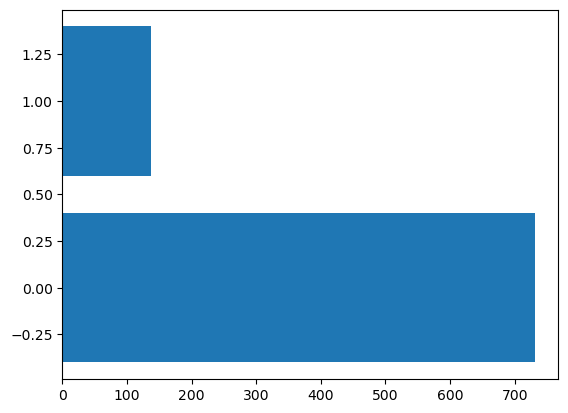

In [29]:
data2 = [12 * 60 + 11, 2 * 60 + 17]

plt.barh(range(len(data2)), data2)

plt.show() 

## Crawl content detail

In [88]:
df.get('content-url')[0]

'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html'

In [89]:
browser = initHeadlessBrowser()
browser.get(df.get('content-url')[0])

2022-12-18 01:38:37.164 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options


In [103]:
def getTableData(browser):
    tableList = browser.find_elements(By.CSS_SELECTOR, 'div.left_block > table')
    tableResult = []
    for table in tableList:
        for tr in table.find_elements(By.TAG_NAME, 'tr'):
            head = tr.find_element(By.TAG_NAME, 'th').text
            data = tr.find_element(By.TAG_NAME, 'td').text
            url = ''
            if head == 'URL':
                url = tr.find_element(By.CSS_SELECTOR, 'td > a').get_attribute('href')
            tableResult.append({
                'head': head,
                'data': data + '|' + url
            })
    return tableResult

In [104]:
getTableData(browser)

[{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플라자 긴자 6F|'},
 {'head': 'URL', 'data': '즈칸 뮤지엄 긴자(ENG)|https://zukan-museum.com/en/'},
 {'head': '주소', 'data': '도쿄도 미나토구 다이바 1-6-1 덱스 도쿄 비치 씨사이드 몰 4F|'},
 {'head': 'URL',
  'data': '도쿄 트릭아트 미궁관(ENG)|https://www.trickart.info/english/index.html'},
 {'head': '주소', 'data': '도쿄도 미나토구 아카사카 5-3-6|'},
 {'head': 'URL',
  'data': '해리 포터를 형상화한 아카사카 사카스의 거리 풍경(JPN)|https://innovation.tbs.co.jp/?world=worldport'}]

In [105]:
def getOpenHours(browser):
    open_hours = browser.find_element(By.CSS_SELECTOR, 'div.opening_hours')
    scheduleList = open_hours.find_elements(By.CSS_SELECTOR, 'li.opening_hours_item')
    return [schedule.text for schedule in scheduleList]

In [106]:
def getPriceInfo(browser):
    price_info = browser.find_element(By.CSS_SELECTOR, 'div.price_info')
    return price_info.text

In [115]:
def getFacilityInfo(browser):
    facilityResult = []
    facility_info = browser.find_element(By.CSS_SELECTOR, 'div.facility_info')
    facilityList = facility_info.find_elements(By.CSS_SELECTOR, 'ul.facility_info_list')
    for facility in facilityList:
        for info in facility.find_elements(By.TAG_NAME, 'li'):
            facilityResult.append(info.text)
    return facilityResult

In [116]:
def getCovidInfo(browser):
    covidInfoList = []
    covid_info = browser.find_element(By.CSS_SELECTOR, 'div.countermeasure_info')
    for info in covid_info.find_elements(By.TAG_NAME, 'li'):
        covidInfoList.append(info.text)
        try:
            covidInfoList.append(info.find_element(By.TAG_NAME, 'a').get_attribute('href'))
        except:
            print()
    return covidInfoList

In [109]:
browser.close()

In [112]:
def getContentDetail(url):
    result = {
        'tableData': [],
        'openHourData': [],
        'priceData': None,
        'facilityInfo': [],
        'covidInfo': []
    }
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        try:
            result['tableData'] = getTableData(browser)
        except Exception as e:
            logger.error('Cannot get table data {}', e)
        try:
            result['openHourData'] = getOpenHours(browser)
        except Exception as e:
            logger.error('Cannot get open hour data {}', e)
        try:
            result['priceData'] = getPriceInfo(browser)
        except Exception as e:
            logger.error('Cannot get price data {}', e)
        try:
            result['facilityInfo'] = getFacilityInfo(browser)
        except Exception as e:
            logger.error('Cannot get facility data {}', e)
        try:
            result['covidInfo'] = getCovidInfo(browser)
        except Exception as e:
            logger.error('Cannot get covid data {}', e)
    except Exception as e:
        logger.error('Cannot get content detail {}', e)
    finally:
        browser.close()
    return result

In [113]:
getContentDetail('https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html')

2022-12-18 02:03:02.152 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 02:03:02.635 | DEBUG    | __main__:getContentDetail:11 - Browser move to url: https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html
2022-12-18 02:03:04.863 | ERROR    | __main__:getContentDetail:20 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x000000010786a34c chromedriver + 754508
4   chromedriver                        0x000000010786a5a1 chromedriver + 755105
5   chromedriver                        0x00000001078ade94 chrom

{'tableData': [{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플라자 긴자 6F|'},
  {'head': 'URL', 'data': '즈칸 뮤지엄 긴자(ENG)|https://zukan-museum.com/en/'},
  {'head': '주소', 'data': '도쿄도 미나토구 다이바 1-6-1 덱스 도쿄 비치 씨사이드 몰 4F|'},
  {'head': 'URL',
   'data': '도쿄 트릭아트 미궁관(ENG)|https://www.trickart.info/english/index.html'},
  {'head': '주소', 'data': '도쿄도 미나토구 아카사카 5-3-6|'},
  {'head': 'URL',
   'data': '해리 포터를 형상화한 아카사카 사카스의 거리 풍경(JPN)|https://innovation.tbs.co.jp/?world=worldport'}],
 'openHourData': [],
 'priceData': None,
 'facilityInfo': [],
 'covidInfo': []}

In [117]:
getContentDetail('https://www.gotokyo.org/kr/spot/186/index.html')

2022-12-18 02:04:33.776 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 02:04:34.271 | DEBUG    | __main__:getContentDetail:11 - Browser move to url: https://www.gotokyo.org/kr/spot/186/index.html


{'tableData': [],
 'openHourData': ['11：00～19：00\n월요일화요일수요일목요일금요일토요일',
  '휴무일: 일요일공휴일비정기 휴무\n*전시 교체 기간'],
 'priceData': '요금\n무료',
 'facilityInfo': ['화장실시설',
  '일본어영어',
  '휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스'],
 'covidInfo': ['입장 제한이 있는 경우 있음',
  '이 시설의 코로나19(COVID-19) 방역대책 관련 정보',
  'https://www.dnpfcp.jp/CGI/gallery/news/detail.cgi?t=1&seq=0000650&y=2020']}

In [34]:
import pandas as pd

In [85]:
df = pd.DataFrame(columns=['location', 'location-url', 'area', 'area-url', 'category', 'content', 'content-url', 'content-img'])
df

,location,location-url,area,area-url,category,content,content-url,content-img


In [86]:
idx = 0;
crawledAreaIdx = 0;
for location, location_url, areaList in placeAndUrlList:
#     print(location, location_url, areaList)
    for area, area_url in areaList:
        if crawledAreaIdx < len(areaCrawlingResult) and idx == areaCrawlingResult[crawledAreaIdx]['idx']:
            for sliderItemList in areaCrawlingResult[crawledAreaIdx]['slidItemList']: # silderTitle, silderItems
#                 print(sliderItemList)
                category = sliderItemList['silderTitle']
                for sliderItem in sliderItemList['silderItems']:
                    content = sliderItem['contentName']
                    content_url = sliderItem['contentDetailURL']
                    content_img = sliderItem['contentImg']
#                     print(location, location_url, area, area_url, category, content, content_url, content_img)
                    df = df.append({
                        'location': location,
                        'location-url': location_url,
                        'area': area,
                        'area-url': area_url,
                        'category': category,
                        'content': content,
                        'content-url': content_url,
                        'content-img': content_img
                    }, ignore_index=True)
            crawledAreaIdx += 1
        else:
#             print(location, location_url, area, area_url)
            df = df.append({
                'location': location,
                'location-url': location_url,
                'area': area,
                'area-url': area_url
            }, ignore_index=True)
        idx += 1

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

In [87]:
df.head()

,location,location-url,area,area-url,category,content,content-url,content-img
0,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,긴자,https://www.gotokyo.org/kr/destinations/centra...,아트・디자인,뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티,https://www.gotokyo.org/kr/new-and-now/new-and...,https://www.gotokyo.org/en/new-and-now/new-and...
1,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,긴자,https://www.gotokyo.org/kr/destinations/centra...,아트・디자인,"음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소",https://www.gotokyo.org/kr/new-and-now/new-and...,https://www.gotokyo.org/en/new-and-now/new-and...
2,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,긴자,https://www.gotokyo.org/kr/destinations/centra...,아트・디자인,긴자 그래픽 갤러리,https://www.gotokyo.org/kr/spot/186/index.html,https://www.gotokyo.org/kr/spot/186/images/444...
3,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,긴자,https://www.gotokyo.org/kr/destinations/centra...,아트・디자인,GINZA PLACE(긴자 플레이스),https://www.gotokyo.org/kr/spot/665/index.html,https://www.gotokyo.org/en/spot/665/images/665...
4,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,긴자,https://www.gotokyo.org/kr/destinations/centra...,아트・디자인,시세이도 갤러리,https://www.gotokyo.org/kr/spot/125/index.html,https://www.gotokyo.org/en/spot/125/images/125...


In [74]:
df.tail()

,location,location-url,area,area-url,category,content,content-url,content-img
807,도쿄 부근 지역,https://www.gotokyo.org/kr/destinations/beyond...,가루이자와,https://www.gotokyo.org/kr/destinations/beyond...,NaN,NaN,NaN,NaN
808,도쿄 부근 지역,https://www.gotokyo.org/kr/destinations/beyond...,이즈반도 아타미・시모다,https://www.gotokyo.org/kr/destinations/beyond...,NaN,NaN,NaN,NaN
809,도쿄 부근 지역,https://www.gotokyo.org/kr/destinations/beyond...,닛코,https://www.gotokyo.org/kr/destinations/beyond...,NaN,NaN,NaN,NaN
810,도쿄 부근 지역,https://www.gotokyo.org/kr/destinations/beyond...,요코하마,https://www.gotokyo.org/kr/destinations/beyond...,NaN,NaN,NaN,NaN
811,도쿄 부근 지역,https://www.gotokyo.org/kr/destinations/beyond...,도쿄 디즈니 리조트®,https://www.gotokyo.org/kr/destinations/beyond...,NaN,NaN,NaN,NaN


In [76]:
df.describe()

,location,location-url,area,area-url,category,content,content-url,content-img
count,812,812,812,812,803,803,803,803
unique,8,8,79,79,46,683,684,639
top,도쿄 도심부,https://www.gotokyo.org/kr/destinations/centra...,오쿠타마 주변,https://www.gotokyo.org/kr/destinations/outlyi...,공원・정원,,https://www.gotokyo.org/shared/images/img_noim...,javascript:void(0);
freq,170,170,66,66,103,39,39,93


In [77]:
df.to_csv('go-tokyo-crawling-result.csv')

## Multi-process, Single-thread

In [13]:
from multiprocessing import Pool
from goTokyoMultiProcess import getAreaInfoProcess, testing, getAreaInfoProcessSingleLine

In [14]:
start = timer()
for place in placeAndUrlList[3:]:
    placeSize = len(place[2])
    logger.debug("place: {} len: {}", place[0], placeSize)
    if placeSize > 0:
        # Create pool of workers
        pool = Pool(placeSize)

        # Map pool of workers to process
        pool.starmap(func=getAreaInfoProcessSingleLine, iterable=place[2])

#         logger.debug("Process close")
#         pool.close()
        logger.debug("Process join")
#         pool.join(30)
        pool.wait(30)
        logger.debug("Sleep time")
        time.sleep(1)
    else:
        logger.debug("place: {} less or equal then 0, {}", place[0], placeSize)

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:38:58.394 | DEBUG    | __main__:<module>:4 - place: 도쿄서부 len: 12
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 신주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 시부야, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.159 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 하라주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-11 01:38:59.159 | INFO

2022-12-11 01:40:07.697 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:08.075 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160 - Crawl slider items result [('쇼핑', [('Hillside Terrace', 'https://www.gotokyo.org/en/spot/547/images/547_0381_1_670x450.jpg', 'https://www.gotokyo.org/kr/spot/547/index.html'), ('다이칸야마의 참신한 패션 공간, 식물과 자연광이 만드는 완전히 아름다운 콜라보레이션을 체감', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/images/190624_thum_400.jpg', 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190624/topics.html'), ('다이칸야마 쓰타야 서점 DAIKANYAMA T-SITE', 'https://www.gotokyo.org/_nopub/kr/20191031_065/images/new65_670x450.jpg', 'javascript:void(0);'), ('르라보 재팬', 'https://www.gotokyo.org/_nopub/en/spot/1316/images/1316_1286_1_670x450.jpg', 'javascript:void(0);'), ('헐리우드 랜치 마켓', 'https://www.gotokyo.org/_nopub/kr/spot/1613/images/1320_1_670x450.jpg', 'javascript:void(0);'), ('메종키츠네 다이칸야마', 'https://www.gotokyo.org/_nopub

2022-12-11 01:40:29.153 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 6
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:152 - Banner removed
2022-12-11 01:40:30.040 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:155 - Crawl slider items
2022-12-11 01:40:30.083 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.085 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 4
2022-12-11 01:40:30.245 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 2
2022-12-11 01:40:30.663 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:30.814 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 3
2022-12-11 01:40:31.206 | DEBUG    | goTokyoMultiProcess:getSlideItems:27 - Slider item list len 1
2022-12-11 01:40:31.255 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:160

KeyboardInterrupt: 

In [ ]:
!echo $$